In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vvbear","key":"c9e9d14b793f153831bf7aa7ff715e19"}'}

In [2]:
!ls -lha kaggle.json


-rw-r--r-- 1 root root 62 May 29 02:08 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 75.7MB/s]
 98% 267M/271M [00:01<00:00, 221MB/s]
100% 271M/271M [00:01<00:00, 218MB/s]
 96% 520M/543M [00:04<00:00, 71.4MB/s]
100% 543M/543M [00:04<00:00, 120MB/s] 


In [6]:
!ls

kaggle.json  sample_data  sampleSubmission.csv	test1.zip  train.zip


In [7]:
from zipfile import ZipFile

file_name = "train.zip"

with ZipFile(file_name, 'r') as zip :
  print("Extracting the files...")
  zip.extractall()
  print("Done")

Extracting the files...
Done


In [8]:
file_name = "test1.zip"

# opening the zip file in read me mode
with ZipFile(file_name, 'r') as zip :
  print("Extracting the files...")
  zip.extractall()
  print("Done")


Extracting the files...
Done


In [9]:
!ls

kaggle.json  sampleSubmission.csv  test1.zip  train.zip
sample_data  test1		   train


In [10]:
import os, cv2, itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

!pip install np_utils

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
import keras as ks

from sklearn.utils import shuffle

!pip install sklearn
import sklearn
from sklearn.model_selection import train_test_split

!pip install livelossplot
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [0]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
TEST_FILE = "test_file.txt"
MODEL_FILE = "model.h5"

In [0]:
TRAIN_DIR = './train/'
TEST_DIR = './test1/'

In [0]:
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_train_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)
        
create_train_data(TRAIN_DIR)
X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)

In [0]:
X, y = shuffle(X, y)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

print("Train shape: {}".format(X_train.shape))
print("Train label shape: {}".format(y_train.shape))
print("Validation shape: {}".format(X_val.shape))
print("Validation label shape: {}".format(y_val.shape))

Train shape: (20000, 80, 80, 1)
Train label shape: (20000,)
Validation shape: (5000, 80, 80, 1)
Validation label shape: (5000,)


In [0]:
X_train = X_train / 255
X_val = X_val / 255

In [0]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3,3), activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 78, 78, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
__________

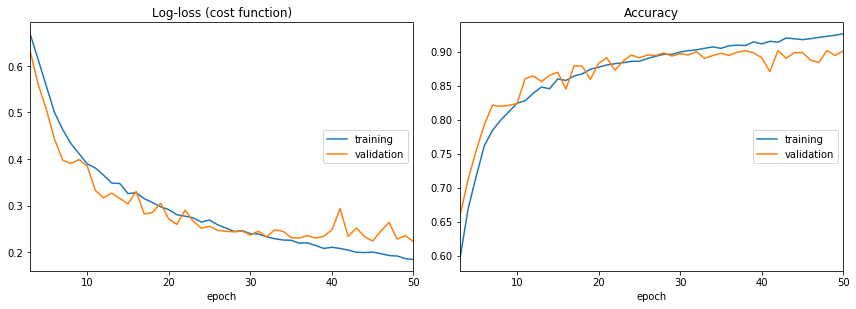

Log-loss (cost function):
training   (min:    0.184, max:    0.694, cur:    0.184)
validation (min:    0.222, max:    0.697, cur:    0.222)

Accuracy:
training   (min:    0.502, max:    0.926, cur:    0.926)
validation (min:    0.493, max:    0.902, cur:    0.901)


In [29]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size = 64, callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")])
model.save_weights(MODEL_FILE)

In [0]:
files.download(MODEL_SUMMARY_FILE)
files.download(TRAINING_LOGS_FILE)
files.download(MODEL_FILE)

In [0]:
X_test = []
id_line = []
def create_test_data(path):
  for p in os.listdir(path):
    id_line.append(p.split(".")[0])
    img_array = cv2.imread(os.path.join(path,p), cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80,80))
    X_test.append(new_img_array)
create_test_data(TEST_DIR)
X_test = np.array(X_test).reshape(-1,80,80,1)
X_test = X_test/255

In [0]:
import tensorflow as tf
global graph,model
graph = tf.get_default_graph()

with graph.as_default():
  predictions = model.predict(X_test)

In [0]:
predicted_val = [int(round(p[0])) for p in predictions]

In [0]:
submission_df = pd.DataFrame({'id':id_line, 'label':predicted_val})

In [0]:
SUBMISSION = "submission.csv"

In [0]:
submission_df.to_csv("submission.csv", index=False)

In [0]:
files.download("submission.csv")

In [0]:
open(TEST_FILE,"w")
probabilities = model.predict(X_test)


In [0]:
files.download(TEST_FILE)

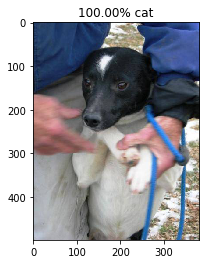

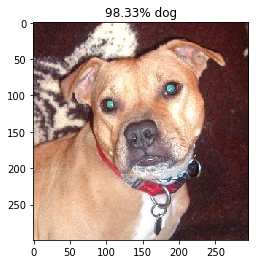

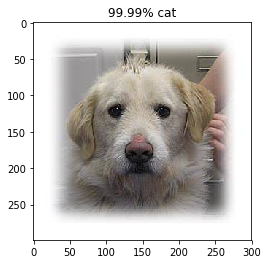

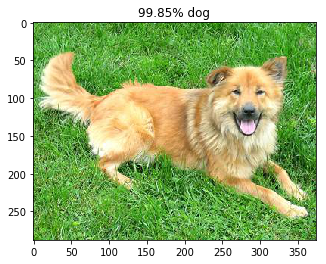

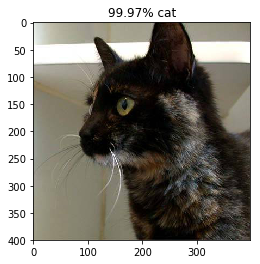

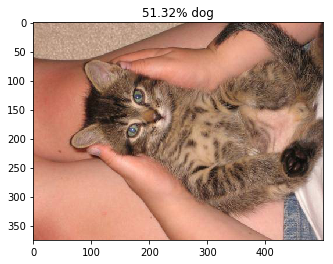

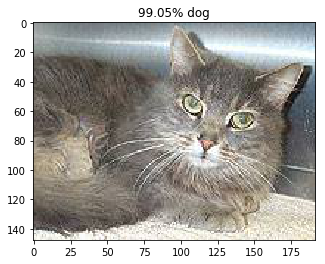

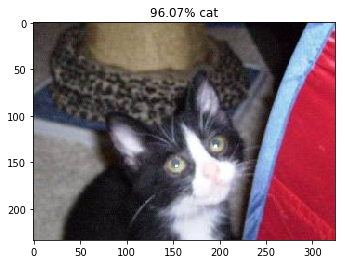

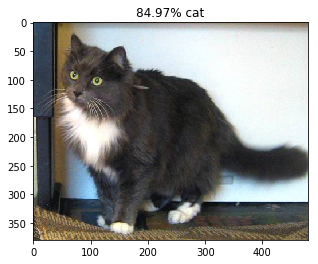

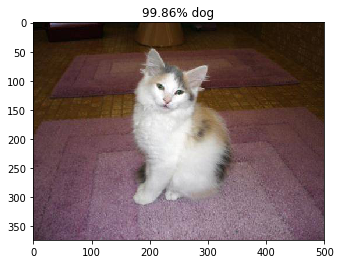

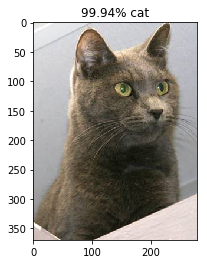

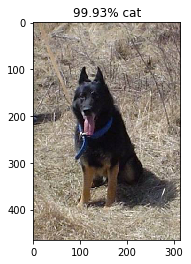

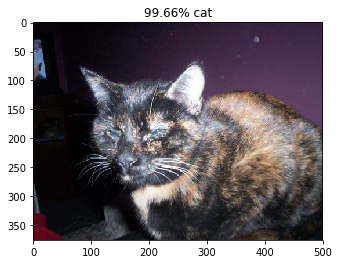

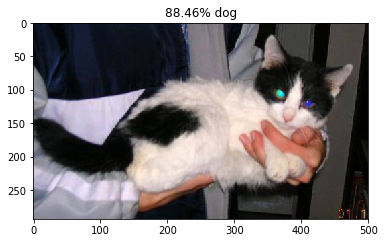

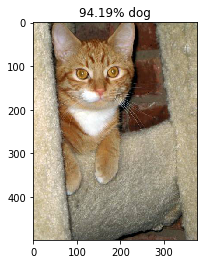

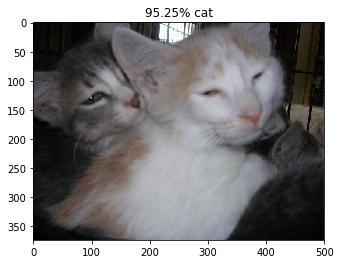

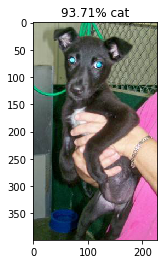

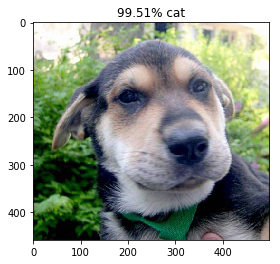

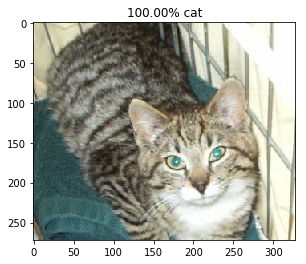

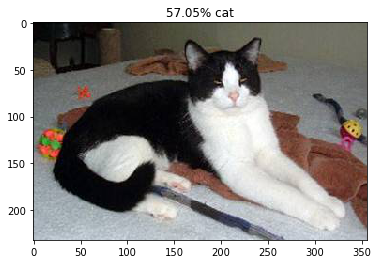

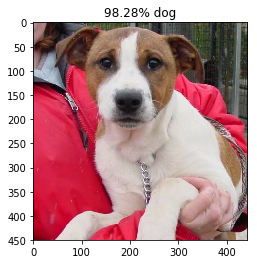

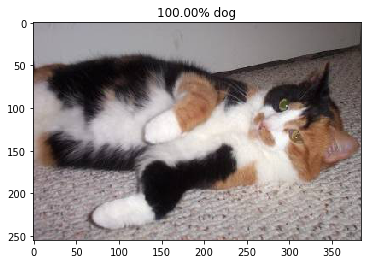

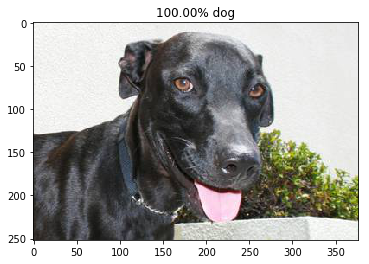

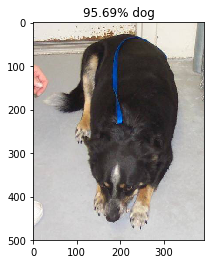

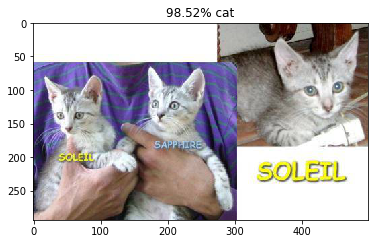

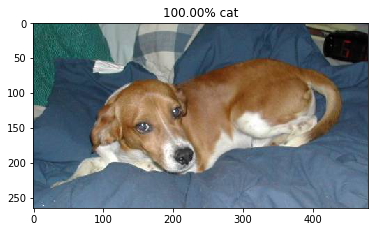

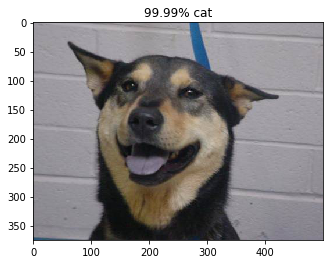

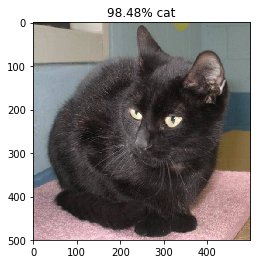

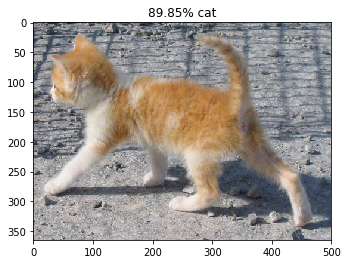

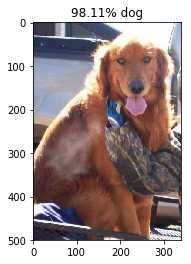

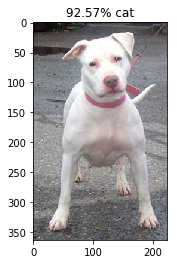

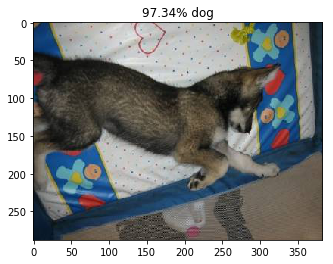

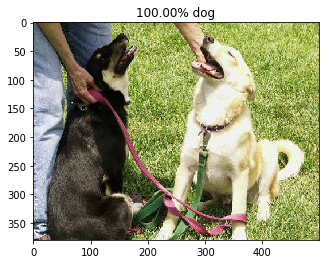

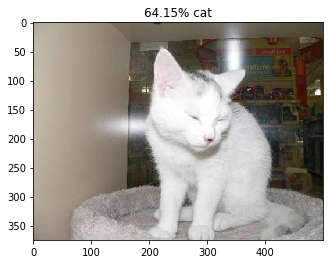

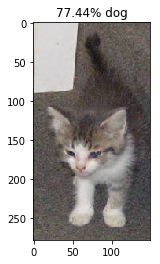

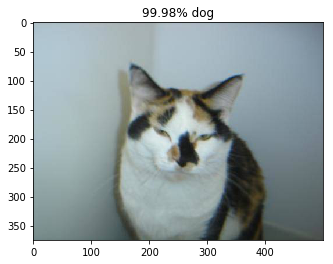

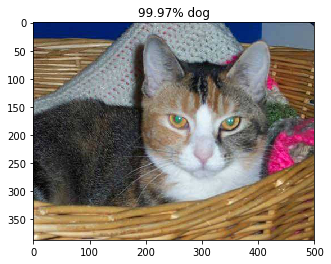

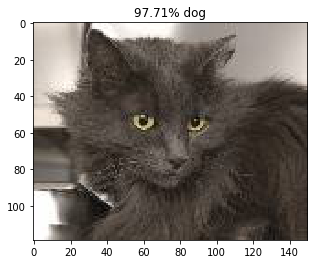

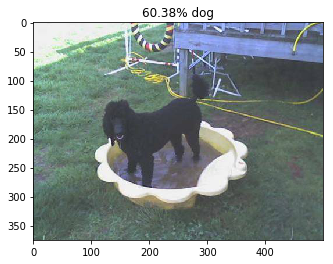

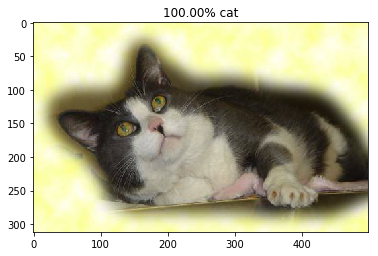

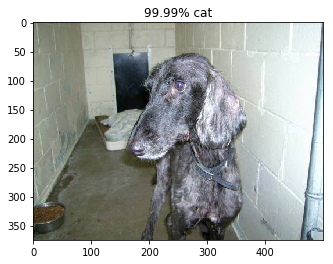

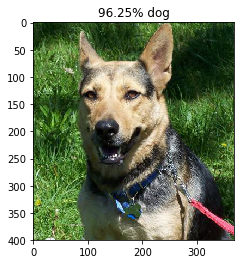

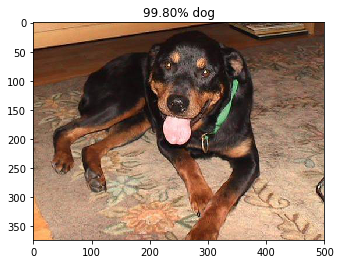

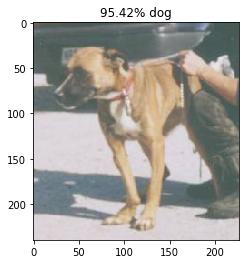

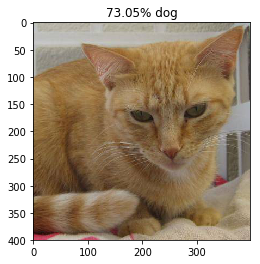

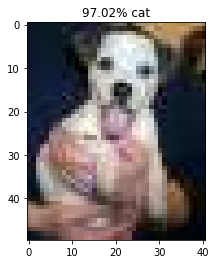

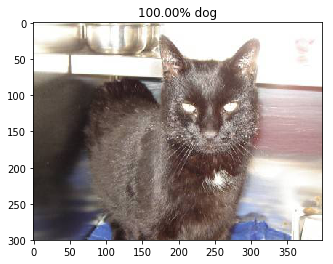

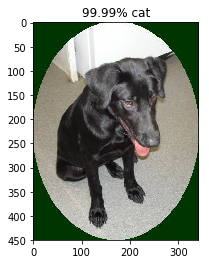

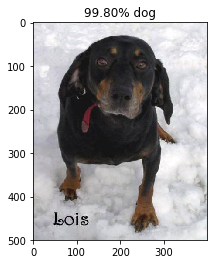

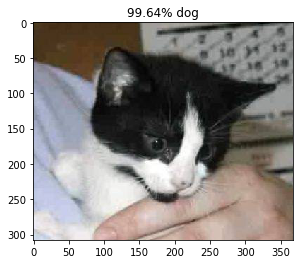

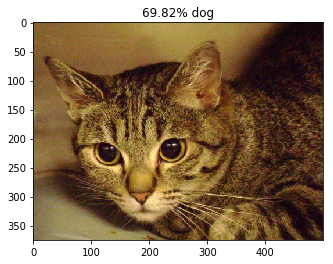

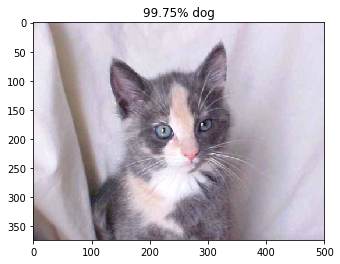

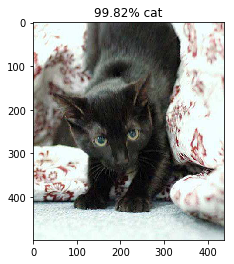

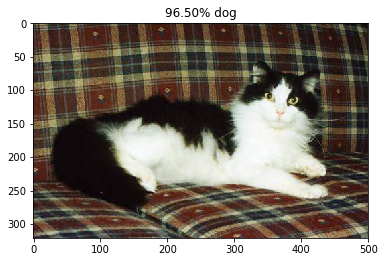

KeyboardInterrupt: ignored

In [38]:
for index, probability in enumerate(probabilities):
    image_path = TEST_DIR + str(index+1) + ".jpg"
    img = mpimg.imread(image_path)
    with open(TEST_FILE,"a") as fh:
        fh.write(str(probability[0]) + " for: " + image_path + "\n")
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()